## 调用此前训练得到准确率最高的模型来进行预测

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# 加载数据
data = pd.read_excel(r'reviewList_translated.xlsx')

In [3]:
# 加载最佳模型和tokenizer
model_path = './best_model.pth'
model_name = 'bert-base-uncased'  # 确保这是你使用的预训练模型名称
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.load_state_dict(torch.load(model_path))
model.eval()

if torch.cuda.is_available():
    model = model.cuda()

# 定义id到label的映射
id2_label = {0: 'negative', 1: 'positive'}

def predict(texts):
    inputs = tokenizer(texts, max_length=250, padding="max_length", truncation=True, return_tensors='pt')
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    return [id2_label[pred] for pred in preds]

# 对每条评论进行预测
predictions = predict(data['content'].tolist())

# 将预测结果添加到原数据中
data['predicted_sentiment'] = predictions

# 保存带有预测结果的数据到新的Excel文件
data.to_excel('reviewList_Predicted.xlsx', index=False)

print("预测完成并已保存到'reviewList_Predicted.xlsx'")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


预测完成并已保存到'reviewList_Predicted.xlsx'


## 1.获取到各个影片正负面的高频词

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re

# 下载必要的nltk数据
# nltk.download('stopwords')
# nltk.download('wordnet')

# 获取英文停用词
stop_words = set(stopwords.words('english'))

# 添加通用高频无意义词到停用词列表
additional_stopwords = ['movie', 'film', 'make', 'know','think','find'
                   'watch', 'sha', 'could', 'also','one','would',
                   'see','first','every','really','even','much','feel']
stop_words.update(additional_stopwords)

# 创建词形还原器
lemmatizer = WordNetLemmatizer()

# 定义一个函数，用于去除停用词、词形还原、过滤非字母字符并统计文本中的词频，获取前20个词
def get_top_20_words(text):
    # 过滤非字母字符
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    # 词形还原并过滤停用词
    filtered_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(20)

# 读取文件
excel_file = pd.ExcelFile('reviewList_Predicted.xlsx')

# 获取指定工作表中的数据
df = excel_file.parse('Sheet1')

# 按id和artificial_identification列进行分组，并对content列中的文本进行词频统计
grouped = df.groupby(['id', 'artificial_identification'])['content'].apply(lambda x: get_top_20_words(' '.join(x))).reset_index()

# 输出结果
print(grouped)

# 保存结果到新的Excel文件
grouped.to_excel('top_20_words.xlsx', index=False)

print("词频统计完成并已保存到'top_20_words.xlsx'")

            id  artificial_identification  \
0   tt10872600                        0.0   
1   tt10872600                        1.0   
2   tt15097216                        0.0   
3   tt15097216                        1.0   
4   tt15239678                        0.0   
5   tt15239678                        1.0   
6   tt15398776                        0.0   
7   tt15398776                        1.0   
8   tt16492678                        0.0   
9   tt16492678                        1.0   
10   tt1745960                        0.0   
11   tt1745960                        1.0   
12  tt23849204                        0.0   
13  tt23849204                        1.0   
14  tt26548265                        0.0   
15  tt26548265                        1.0   
16  tt29623480                        0.0   
17  tt29623480                        1.0   
18   tt9362722                        0.0   
19   tt9362722                        1.0   

                                              content 

## 2.获取影片的正负面评价高频词柱状图和TD-IDF

e:\software\Programmingsoftware\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


=== 正面评价高频词 ===


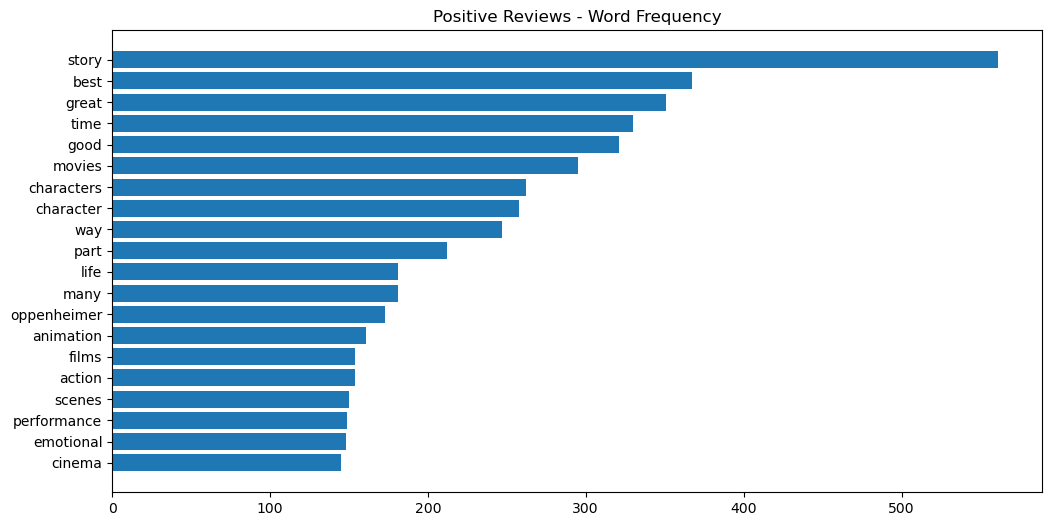


=== 负面评价高频词 ===


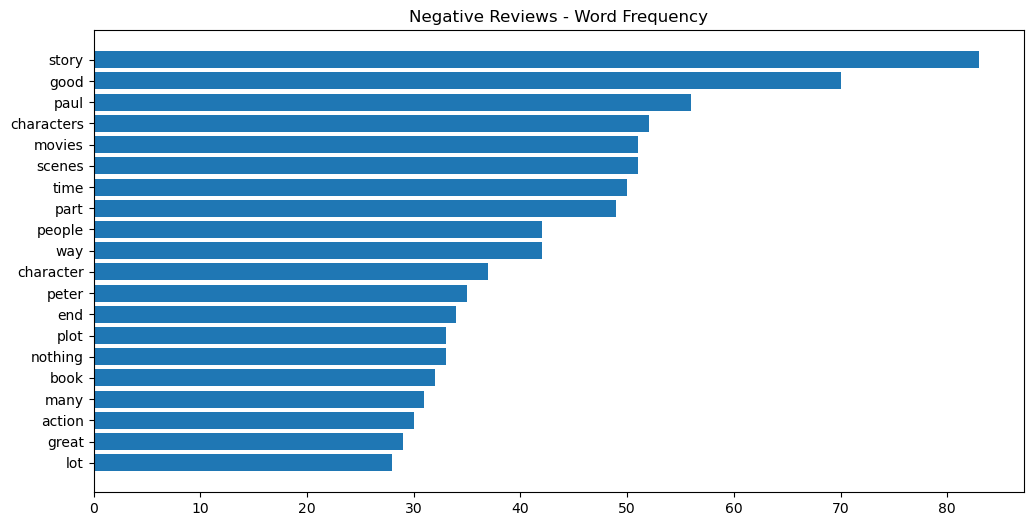


=== 正面评价TF-IDF关键词 ===


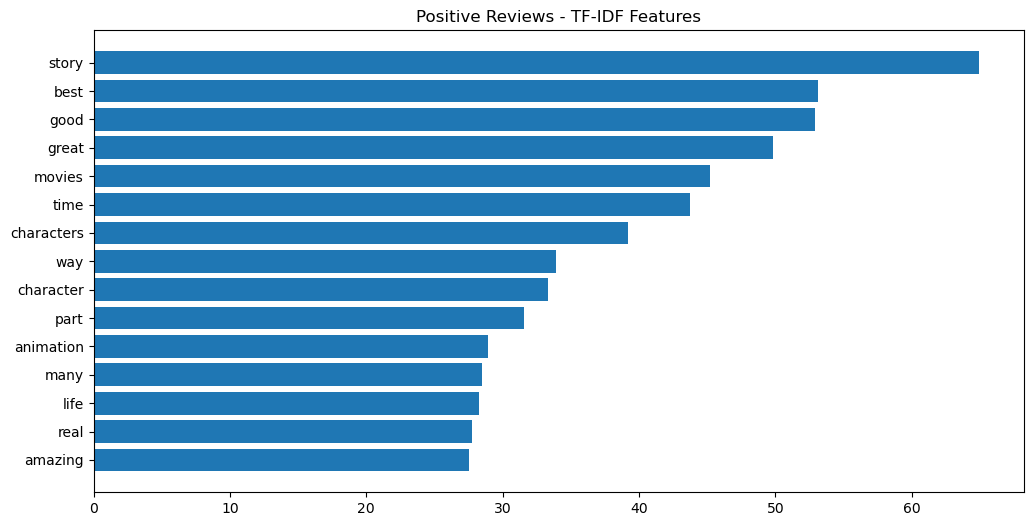


=== 负面评价TF-IDF关键词 ===


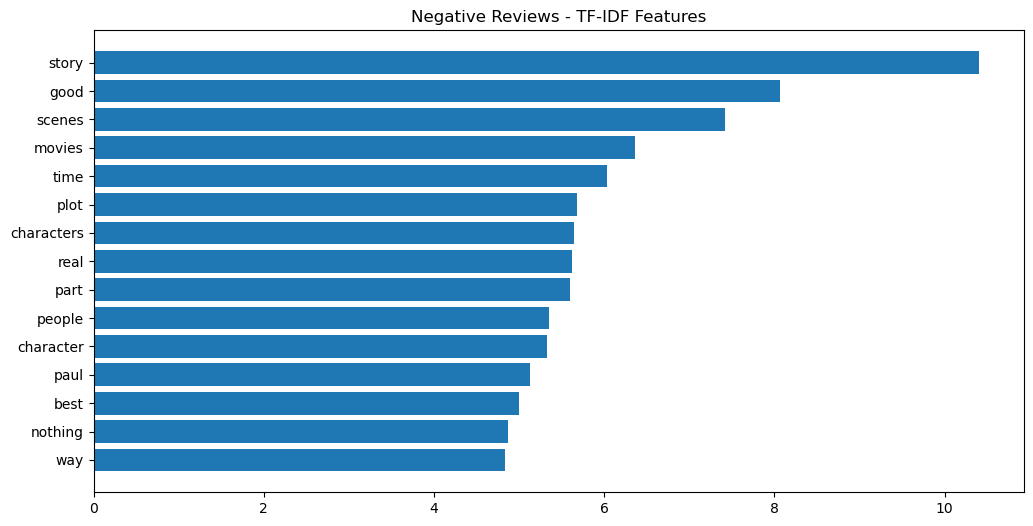

In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt


# 自定义配置
REVIEW_COLUMN = 'content'  # 评论内容列名
SENTIMENT_COLUMN = 'artificial_identification'  # 情感标签列名
CUSTOM_STOPWORDS = ['movie', 'film', 'make', 'know','think','find'
                   'watch', 'sha', 'could', 'also','one','would',
                   'see','first','every','really','even','much','feel']  # 列表类型

# 加载数据
df = pd.read_excel('reviewList_Predicted.xlsx')

# 扩展停用词表
stop_words = list(stopwords.words('english'))  # 转换为列表
stop_words.extend(CUSTOM_STOPWORDS)  # 用extend替代update

# 词性过滤函数（保留名词和形容词）
def filter_pos(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    return [word for word, tag in tagged if tag in ['NN', 'NNS', 'JJ', 'JJR', 'JJS']]

# 预处理流程
def preprocess(text):
    tokens = filter_pos(text)
    return [word for word in tokens if 
            word.isalpha() and 
            word not in stop_words and 
            len(word) > 2]

# 分割正负面评价
positive_reviews = df[df[SENTIMENT_COLUMN] == 1][REVIEW_COLUMN]
negative_reviews = df[df[SENTIMENT_COLUMN] == 0][REVIEW_COLUMN]

# 生成词频统计
def get_top_words(reviews, n=20):
    all_words = []
    for review in reviews.dropna():
        all_words.extend(preprocess(review))
    return Counter(all_words).most_common(n)

# 使用TF-IDF提取特征词
def get_tfidf_features(reviews, n=15):
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=100,
        stop_words=stop_words,
        tokenizer=preprocess
    )
    matrix = tfidf.fit_transform(reviews.dropna())
    return sorted(zip(tfidf.get_feature_names_out(), matrix.sum(axis=0).A1), 
                 key=lambda x: x[1], reverse=True)[:n]

# 可视化结果
def plot_top_words(counter, title):
    words, counts = zip(*counter)
    plt.figure(figsize=(12,6))
    plt.barh(words[::-1], counts[::-1])  # 反转顺序使最高值在顶部
    plt.title(title)
    plt.show()

# 执行分析
if __name__ == "__main__":
    # 词频分析
    pos_word_freq = get_top_words(positive_reviews)
    neg_word_freq = get_top_words(negative_reviews)
    
    # TF-IDF分析
    pos_tfidf = get_tfidf_features(positive_reviews)
    neg_tfidf = get_tfidf_features(negative_reviews)
    
    # 显示结果
    print("=== 正面评价高频词 ===")
    plot_top_words(pos_word_freq, "Positive Reviews - Word Frequency")
    
    print("\n=== 负面评价高频词 ===")
    plot_top_words(neg_word_freq, "Negative Reviews - Word Frequency")
    
    print("\n=== 正面评价TF-IDF关键词 ===")
    plot_top_words(pos_tfidf, "Positive Reviews - TF-IDF Features")
    
    print("\n=== 负面评价TF-IDF关键词 ===")
    plot_top_words(neg_tfidf, "Negative Reviews - TF-IDF Features")

    # 输出表格结果
    pd.DataFrame(pos_tfidf, columns=['Word', 'Score']).to_csv('positive_keywords.csv', index=False)
    pd.DataFrame(neg_tfidf, columns=['Word', 'Score']).to_csv('negative_keywords.csv', index=False)


## 3.给各个影片做详细的词频统计分析和TD-IDF分析，包括扩展停用词表、添加词性过滤函数（保留名词和形容词）、生成词频统计以及使用TF-IDF提取特征词

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import os

# # 下载NLTK资源
# nltk.download(['punkt', 'stopwords', 'averaged_perceptron_tagger', 'wordnet'])

# 初始化词形还原器
lemmatizer = WordNetLemmatizer()

# 自定义配置
REVIEW_COLUMN = 'content'  # 评论内容列名
SENTIMENT_COLUMN = 'artificial_identification'  # 情感标签列名
MOVIE_COLUMN = 'id'  # 影片名称列名
CUSTOM_STOPWORDS = ['movie', 'film', 'make', 'know','think','find'
                   'watch', 'sha', 'could', 'also','one','would',
                   'see','first','every','really','even','much','feel']  # 扩展停用词

# 加载数据
df = pd.read_excel('reviewList_Predicted.xlsx')

# 初始化停用词表
stop_words = list(stopwords.words('english'))
stop_words.extend(CUSTOM_STOPWORDS)

# 改进的词性过滤函数（带词形还原）
def filter_pos(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    filtered = []
    for word, tag in tagged:
        # 确定词性标注
        if tag.startswith('NN'):  # 名词
            pos = 'n'
        elif tag.startswith('JJ'):  # 形容词
            pos = 'a'
        elif tag.startswith('VB'):  # 动词
            pos = 'v'
        else:
            pos = 'n'  # 默认按名词处理
        
        # 词形还原
        lemma = lemmatizer.lemmatize(word, pos=pos)
        filtered.append(lemma)
    return filtered

# 预处理流程
def preprocess(text):
    tokens = filter_pos(str(text))  # 确保处理字符串
    return [word for word in tokens if 
            word.isalpha() and 
            word not in stop_words and 
            len(word) > 2]

# 分析工具函数
def analyze_reviews(reviews, label):
    """统一分析处理方法"""
    print(f"\n=== {label}分析 ===")
    
    # 词频分析
    word_freq = Counter()
    for review in reviews.dropna():
        word_freq.update(preprocess(review))
    top_words = word_freq.most_common(20)
    
    # TF-IDF分析
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=100,
        stop_words=stop_words,
        tokenizer=preprocess,
        token_pattern=None  # 消除token_pattern警告
    )
    matrix = tfidf.fit_transform(reviews.dropna())
    tfidf_features = sorted(zip(tfidf.get_feature_names_out(), matrix.sum(axis=0).A1), 
                          key=lambda x: x[1], reverse=True)[:15]
    
    return top_words, tfidf_features

def save_analysis_results(movie_name, pos_results, neg_results):
    """保存分析结果到文件"""
    output_dir = f"analysis_results/{movie_name}"
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存词频结果
    pd.DataFrame(pos_results[0], columns=['Word', 'Count']).to_csv(
        f"{output_dir}/positive_word_freq.csv", index=False)
    pd.DataFrame(neg_results[0], columns=['Word', 'Count']).to_csv(
        f"{output_dir}/negative_word_freq.csv", index=False)
    
    # 保存TF-IDF结果
    pd.DataFrame(pos_results[1], columns=['Word', 'Score']).to_csv(
        f"{output_dir}/positive_tfidf.csv", index=False)
    pd.DataFrame(neg_results[1], columns=['Word', 'Score']).to_csv(
        f"{output_dir}/negative_tfidf.csv", index=False)

# 主分析流程
def main_analysis():
    # 按影片分析
    for movie in df[MOVIE_COLUMN].unique():
        print(f"\n正在分析影片: {movie}")
        movie_df = df[df[MOVIE_COLUMN] == movie]
        
        # 分割正负面评价
        pos_reviews = movie_df[movie_df[SENTIMENT_COLUMN] == 1][REVIEW_COLUMN]
        neg_reviews = movie_df[movie_df[SENTIMENT_COLUMN] == 0][REVIEW_COLUMN]
        
        # 执行分析
        pos_analysis = analyze_reviews(pos_reviews, "正面评价")
        neg_analysis = analyze_reviews(neg_reviews, "负面评价")
        
        # 保存结果
        save_analysis_results(movie, pos_analysis, neg_analysis)
        
    # 整体分析
    print("\n正在执行整体分析...")
    pos_all = analyze_reviews(df[df[SENTIMENT_COLUMN] == 1][REVIEW_COLUMN], "整体正面评价")
    neg_all = analyze_reviews(df[df[SENTIMENT_COLUMN] == 0][REVIEW_COLUMN], "整体负面评价")
    save_analysis_results("OVERALL", pos_all, neg_all)

if __name__ == "__main__":
    main_analysis()
    print("\n分析完成！结果已保存在analysis_results目录")



正在分析影片: tt9362722

=== 正面评价分析 ===


e:\software\Programmingsoftware\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['might', 'must', 'need'] not in stop_words.
  warnings.warn(



=== 负面评价分析 ===

正在分析影片: tt1745960

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt15097216

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt29623480

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt15398776

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt10872600

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt15239678

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt23849204

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt16492678

=== 正面评价分析 ===

=== 负面评价分析 ===

正在分析影片: tt26548265

=== 正面评价分析 ===

=== 负面评价分析 ===

正在执行整体分析...

=== 整体正面评价分析 ===

=== 整体负面评价分析 ===

分析完成！结果已保存在analysis_results目录
